<a href="https://colab.research.google.com/github/karanpreetkaur/instacart_market_basket_analysis/blob/main/Instacart_market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
%%capture
!sudo apt-get update --fix-missing

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
#!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

!mv spark-3.0.0-bin-hadoop3.2.tgz sparkkk
!tar xf sparkkk
!pip install -q findspark

In [53]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('fpgrowth') \
    .getOrCreate()

spark   

### Imports

In [54]:
from pyspark.sql.functions import when
from pyspark.sql.functions import collect_set, col, count
from pyspark.sql.functions import size

from pyspark.ml.fpm import FPGrowth

import altair as alt
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [55]:
alt.data_transformers.disable_max_rows()
alt.renderers.enable('colab')

RendererRegistry.enable('colab')

## Market Basket Analysis using Instacart Online Grocery Dataset

Which products will an Instacart consumer purchase again?

In [56]:
# Import data in spark dataframes
aisles = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/aisles.csv/aisles.csv", header=True)
departments = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/departments.csv/departments.csv", header=True)
order_products_prior = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/order_products__prior.csv/order_products__prior.csv", header=True)
order_products_train = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/order_products__train.csv/order_products__train.csv", header=True)
orders = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/orders.csv/orders.csv", header=True)
products = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/products.csv/products.csv", header=True)

# Exploratory Data Analysis



### Find busiest day of week

In [57]:
orders = orders.withColumn("order_dow", when(orders['order_dow'] == 0, 'Sunday')
                                        .when(orders['order_dow'] == 1, 'Monday')
                                        .when(orders['order_dow'] == 2, 'Tuesday')
                                        .when(orders['order_dow'] == 3, 'Wednesday')
                                        .when(orders['order_dow'] == 4, 'Thursday')
                                        .when(orders['order_dow'] == 5, 'Friday')
                                        .when(orders['order_dow'] == 6, 'Saturday'))

In [58]:
orders_dow_count = orders.groupBy('order_dow').count()

In [59]:
orders_dow_count = orders_dow_count.toPandas()

In [60]:
chart = alt.Chart(orders_dow_count, title='Popular day of week for orders').encode(x=alt.X('order_dow', sort = '-y', title='Day of week'),
                                   y=alt.Y('count', axis = alt.Axis(format = 's'), title='Total order count'), 
                                   color = 'order_dow',
                                   tooltip='count').mark_bar().properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)

chart

alt.Chart(...)

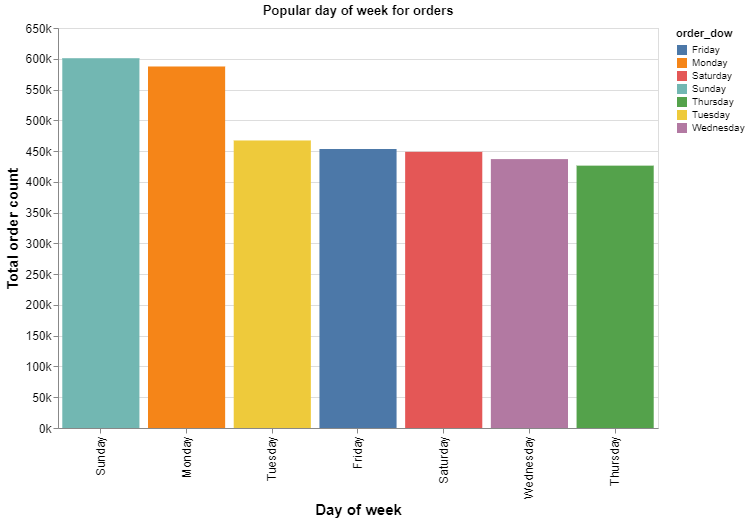

In [61]:
#@title Popular Day of week for orders
from IPython.display import Image
Image("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/images/day_of_week.png") 

## Breakdown of orders by hour of day

In [73]:
busiest_orders_hours = orders.groupBy('order_hour_of_day').count().toPandas()

In [74]:
busiest_orders_hours_line = (alt.Chart(busiest_orders_hours).encode(x = alt.X('order_hour_of_day', 
                                                                              title='Hour of day (hh)'),
                                                                    y = alt.Y('count', axis = alt.Axis(format='s'), 
                                                                              title = 'Total order count'),
                                                                    tooltip = 'count')
                                                            .mark_line()).properties(width = 600, height = 400)
busiest_orders_hours_chart = (busiest_orders_hours_line + busiest_orders_hours_line.mark_point(color = 'black')).configure_axis(labelFontSize=12, titleFontSize = 15)

busiest_orders_hours_chart

alt.LayerChart(...)

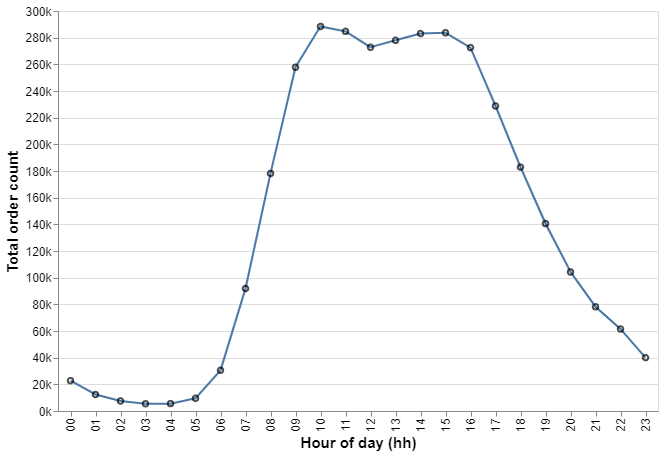

In [75]:
#@title Popular hour of day for orders
from IPython.display import Image
Image("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/images/busiest_hour_of_day.png") 

# Products of Department in reorders

In [14]:
max_department_product = (order_products_train.join(products, on='product_id', how='inner').join(departments, on='department_id')).select('order_id', 'department', 'reordered')
max_department_product = max_department_product.filter(max_department_product.reordered == 1)
max_department_product = max_department_product.groupBy('department').count().toPandas()

In [77]:
reorder_product_department_chart = (alt.Chart(max_department_product).encode(x = alt.X('department', sort = '-y', title='Department'),
                                         y = alt.Y('count', title = 'Product of department in reorders', axis=alt.Axis(format='s')),
                                         color = 'department',
                                         tooltip= 'count').mark_bar()).properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)

reorder_product_department_chart                                      

alt.Chart(...)

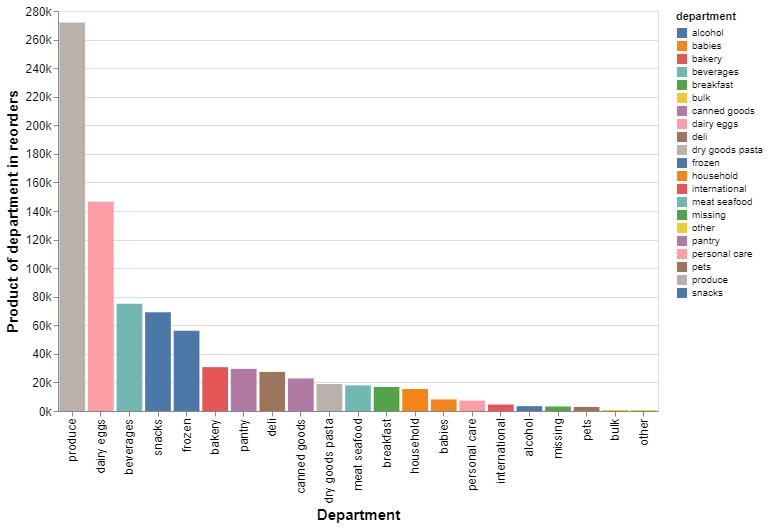

In [78]:
#@title Department of products with Maximum reorders
from IPython.display import Image
Image("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/images/reorder_department.png") 

# Top 10 Popular Reordered Items

In [16]:
reorder_products = order_products_train.join(products, on='product_id', how='inner')
reorder_products = reorder_products.filter(reorder_products.reordered == 1).select('product_name', 'order_id')
reorder_products = reorder_products.groupBy('product_name').count().orderBy('count', ascending = False).limit(20)

In [17]:
reorder_products.show(20, False)

+--------------------------+-----+
|product_name              |count|
+--------------------------+-----+
|Banana                    |16557|
|Bag of Organic Bananas    |13362|
|Organic Strawberries      |8603 |
|Organic Baby Spinach      |8055 |
|Organic Avocado           |6226 |
|Organic Hass Avocado      |6042 |
|Large Lemon               |5923 |
|Strawberries              |4786 |
|Organic Raspberries       |4279 |
|Limes                     |4234 |
|Organic Whole Milk        |4174 |
|Organic Blueberries       |3384 |
|Organic Zucchini          |3266 |
|Organic Yellow Onion      |3094 |
|Organic Garlic            |3041 |
|Organic Cucumber          |3007 |
|Seedless Red Grapes       |2869 |
|Organic Grape Tomatoes    |2727 |
|Sparkling Water Grapefruit|2662 |
|Honeycrisp Apple          |2655 |
+--------------------------+-----+



In [18]:
reorder_products_top10 = reorder_products.limit(10).toPandas()
(alt.Chart(reorder_products_top10).encode(x = alt.Y('product_name', sort = '-y', title = 'Product name'),
                                   y = alt.Y('count', title = 'Presence in orders'),
                                   color = 'product_name').mark_bar()).properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)


alt.Chart(...)

# Organic wins!

(-0.5, 399.5, 199.5, -0.5)

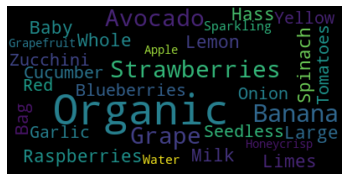

In [19]:
reorder_products = reorder_products.toPandas()
wordcloud = WordCloud(max_font_size=50).generate(' '.join(reorder_products.product_name))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Organize and View Shopping Basket

In [20]:
raw_data = order_products_train.join(products, on='product_id')
baskets = raw_data.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.show(20, False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                                                                                                                                                                                                                                                                                              

In [21]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)
model = fpGrowth.fit(baskets)

# Most Frequent Itemsets

In [22]:
# Display frequent itemsets.
freq_itemsets = model.freqItemsets
freq_itemsets = freq_itemsets.filter(size(freq_itemsets.items) > 2).orderBy('freq', ascending= False).show(20, False)

KeyboardInterrupt: ignored

In [ ]:
# Display generated association rules.
associationRules = model.associationRules
associationRules = (associationRules.withColumnRenamed('antecedent', 'antecedent(if)')
                                   .withColumnRenamed('consequent', 'consequent(then)')).orderBy('confidence', ascending=False)
associationRules.show(20, False)

# Surprise Recommendation model
Simple Python Recommendation System Engine

In [ ]:
pip install surprise

In [ ]:
from surprise import Dataset

In [ ]:
orders.show()

In [ ]:
order_user_reorder_df = order_products_prior.join(orders, on='order_id', how='inner').select('user_id', 'product_id', 'reordered')


In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
order_user_reorder_df = order_user_reorder_df.withColumn("reordered", order_user_reorder_df["reordered"].astype(IntegerType()))

In [ ]:
order_user_reorder_df = order_user_reorder_df.groupBy('user_id', 'product_id').sum('reordered').withColumnRenamed('sum(reordered)', 'frequency')

In [ ]:
order_user_reorder_df.show()

In [ ]:
order_user_reorder_df = order_user_reorder_df[order_user_reorder_df['frequency'] >= 1]

In [ ]:
order_user_reorder_df[order_user_reorder_df['user_id'] == 1].show()

Maximum reorder frequency is 98

In [ ]:
order_user_reorder_df.agg({'frequency':'max'}).collect()[0][0]

Users who did maximum reorders

In [ ]:
order_user_reorder_df[order_user_reorder_df['frequency'] == 98].show()

In [ ]:
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate

In [ ]:
order_user_reorder_df = order_user_reorder_df.toPandas()

In [ ]:
order_user_reorder_df[(order_user_reorder_df['user_id'] == 196) & (order_user_reorder_df['product_id'] == 13176)]

In [ ]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 100))

# The columns must correspond to user id, item id and ratings (in that order).
reorder_data = Dataset.load_from_df(order_user_reorder_df, reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(reorder_data, test_size=.25, random_state=12)

In [ ]:
# We'll use the famous SVD algorithm.
algo = SVD()
algo.fit(trainset)

In [ ]:
uid=196
iid=13176
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=2, verbose=True)